In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/CondNet')

In [3]:
from tqdm.notebook import tqdm

import importlib
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor, Size
from torch import autograd
from torch.nn import Module
from typing import Optional
from torch.nn import functional as F

import fcn
from CondNet import CondNet
import img_utils as iu
import loss_iter

In [ ]:
importlib.reload(iu)
importlib.reload(loss_iter)

<module 'loss' from '/content/drive/My Drive/Colab Notebooks/CondNet/loss.py'>

In [ ]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [ ]:
iu.gen_images(10000)

In [4]:
torch.manual_seed(0)
np.random.seed(0)

test_net = CondNet(3)
# test_net.cond_net.cuda()
# test_net.fcn_model.cuda()
loss_func = loss_iter.CondLoss(loss_function=nn.BCEWithLogitsLoss(reduce=False), q_min=0.2, supression=0.5, cond_weight=0.2)

opt1 = optim.Adam(test_net.parameters(), lr=5*10**(-5), weight_decay=0.01)

In [ ]:
ds = iu.ImageDataset('image_*.npy', 'mask_*.npy', 'matrix_*.npy')

In [ ]:
dataloader = torch.utils.data.DataLoader(ds, batch_size=100, shuffle=False)#, collate_fn=lambda batch: [(dp[0], dp[1], dp[2]) for dp in batch])

In [ ]:
n_epochs = 20
# torch.autograd.set_detect_anomaly = True
loss_vs_epoch = []
test_net.float()
test_net.train()
sigmoid = nn.Sigmoid()
for epoch in tqdm(range(n_epochs)):
    temp_loss = 0
    for i, (data, mask, matrix) in enumerate(dataloader):
        opt1.zero_grad()
        data = data.cuda().float()
        mask = mask.cuda().float()
        matrix = matrix.cuda().float()
        try:
          with autograd.detect_anomaly():
            output = test_net(data)
            curr_loss = loss_func(sigmoid(output[:, 0, :, :]), matrix, output[:, 1:4, :, :], mask).mean()
            curr_loss.backward()
            opt1.step()
        except Exception as e:
          print(i, curr_loss)
          print(e)
          raise
        temp_loss += curr_loss.item() * data.size(0)
    loss_vs_epoch.append(temp_loss / len(dataloader.sampler))
    print(f"Epoch: {epoch}, Loss: {loss_vs_epoch[-1]}")
    torch.save(test_net.state_dict(), 'net_my_fcn.pt')

torch.save(test_net.state_dict(), '/content/drive/My Drive/Colab Notebooks/CondNet/net_my_fcn.pt')

/usr/local/lib/python3.6/dist-packages/torch/autograd/anomaly_mode.py:70: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  warnings.warn('Anomaly Detection has been enabled. '


0.2464980185031891


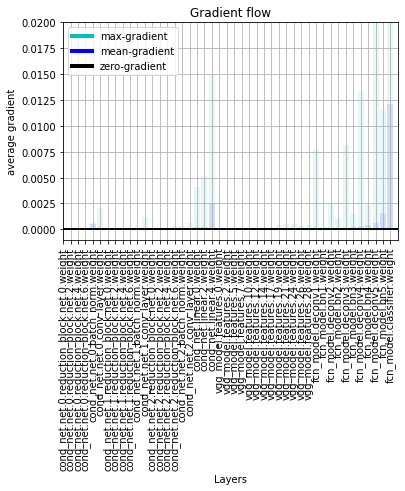

In [ ]:
# test_net.cond_net.cuda()
# test_net.fcn_model.cuda()
test_net.train()

# data = data.cuda().float()
# mask = mask.cuda().float()
data = data.float()
mask = mask.float()
matrix = matrix.float()

opt1.zero_grad()
output = test_net(data)
with autograd.detect_anomaly():
  curr_loss = loss_func(nn.Sigmoid()(output[0]), matrix, output[1], mask).sum()
  print(curr_loss.item())
  curr_loss.backward()
  opt1.step()
plot_grad_flow(test_net.named_parameters())

In [ ]:
from matplotlib.lines import Line2D   

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [ ]:


test_net.cond_net.cuda()
test_net.train()
for i, (data, mask, matrix) in enumerate(dataloader):
  if (i < 9):
    print(f"i is {i}")
    data = data.cuda().float()
    mask = mask.cuda().float()
    matrix = matrix.cuda().float()
    with autograd.detect_anomaly():
      opt1.zero_grad()
      output = test_net(data)
      test_matrix = matrix.reshape(matrix.shape[0], matrix.shape[1], -1)
      test_out = nn.Sigmoid()(output[:, 0, :, :])
      test_beta = test_out.reshape(test_out.shape[0], -1)
      print(torch.sum(test_beta < -1), torch.sum(test_beta > 1))
      test_q = loss_func.atanh(test_beta) ** 2 + loss_func.q_min
      print(f"q not nan: {torch.sum(torch.isnan(test_q))}")
      print(f"q max: {torch.max(test_q - loss_func.q_min, dim=1)}")
      test_noise = (torch.sum(test_matrix, dim=1) < 1).float()
      print(f"Noise vertices: {torch.sum(test_noise, dim=1)}")
      print(f"test_noise : {torch.sum((1 - test_noise) * (test_q - loss_func.q_min), dim=1)}")
      temp_general_loss = loss_func.general_loss(test_noise, test_q, output[:, 1:4, :, :], mask)
      temp_background_loss = loss_func.background_loss(test_beta, test_matrix, test_noise, test_matrix.shape[1])
      temp_potential_loss = loss_func.potential_loss(test_q, test_matrix, 64, 64, test_matrix.shape[1])
      print(f"General loss: {temp_general_loss}")
      print(f"Background loss: {temp_background_loss}")
      print(f"Potential loss: {temp_potential_loss}")
      print(f"Overall loss: {(temp_general_loss + loss_func.cond_weight * (temp_background_loss + temp_potential_loss)).mean()}")
      # print(test_noise.shape)
      # print(test_noise)
      # print(torch.sum(torch.eq(test_noise, 0)), torch.sum(torch.isnan(test_out)), torch.sum(torch.isnan(output[1])))
      if i < 8:
        curr_loss = loss_func(test_out, matrix, output[:, 1:4, :, :], mask)
        print(torch.sum(torch.isnan(curr_loss)))
        print(curr_loss.item())
        curr_loss.backward()
        opt1.step()

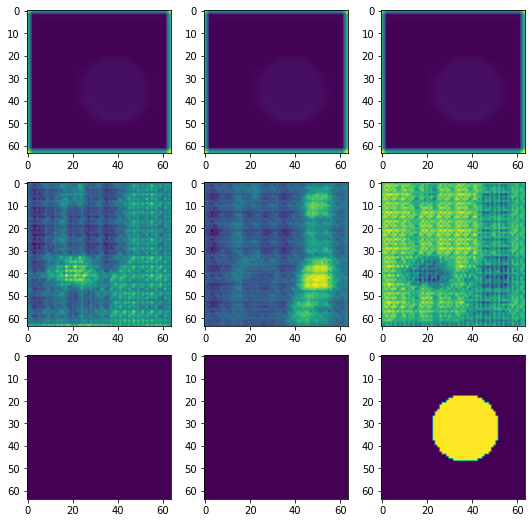

In [ ]:
item = 7

data, mask, _ = ds[item]

data = data.unsqueeze(0).cuda().float()
test_net.eval()
test_out = test_net(data)


fig, ax = plt.subplots(3, 3, figsize=(9,9))



ax[0, 0].imshow(test_out[0][0, :, :].cpu().data.numpy())
ax[0, 1].imshow(test_out[0][0, :, :].cpu().data.numpy())
ax[0, 2].imshow(test_out[0][0, :, :].cpu().data.numpy())

ax[1, 0].imshow(test_out[1][0, 0, :, :].cpu().data.numpy())
ax[1, 1].imshow(test_out[1][0, 1, :, :].cpu().data.numpy())
ax[1, 2].imshow(test_out[1][0, 2, :, :].cpu().data.numpy())

ax[2, 0].imshow(mask[ 0, :, :].cpu().data.numpy())
ax[2, 1].imshow(mask[1, :, :].cpu().data.numpy())
ax[2, 2].imshow(mask[2, :, :].cpu().data.numpy())

plt.show()

plt.show()